In [91]:
#import Pkg
#Pkg.add("JuMP")
#Pkg.add("GLPK")
#Pkg.add("Gruobi")
#Pkg.add("DataFrames")
#Pkg.add("CSV")

In [92]:
using JuMP, GLPK
using DataFrames
using CSV

In [93]:
#load cost data
con_generation = CSV.File("../data/conventional_generators.csv") |> DataFrame

#load wind_technicaldata
wind_generation = CSV.File("../data/wind_farms.csv") |> DataFrame

# load wind profile
wind_profile = CSV.File("../data/wind_powerprofile_200.csv") |> DataFrame


Row,Hour,W1,W2,W3,W4,W5,W6
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,76.8921,101.54,92.8003,95.3709,96.002,70.9073
2,2,66.8277,90.9989,109.167,107.937,103.616,112.618
3,3,78.422,116.959,142.88,134.78,128.276,133.832
4,4,64.1437,134.249,159.57,133.664,142.969,154.233
5,5,102.22,145.507,160.944,165.303,144.03,161.49
6,6,134.039,131.112,157.023,161.828,144.636,155.222
7,7,146.517,153.67,141.566,159.927,152.86,153.604
8,8,143.176,163.392,155.294,170.805,158.643,164.307
9,9,163.297,144.48,172.638,185.318,150.901,166.558


In [94]:
#demand bids
name = "demand_hour_0.csv"
demand_bids = CSV.File("../data/demand_bids_hour/" * name) |> DataFrame
 
# number of convential generators
 G = size(con_generation, 1)

 # number of demand
 D = size(demand_bids, 1)

 # number of wind generators
 W = size(wind_generation, 1)

4

In [95]:
# Initialize the DataFrame directly without dynamic column names
result_df = DataFrame(hour = Int[], objective_value = Float64[])
equilibrium_df = DataFrame(hour = Int[], market_price = Float64[], market_quantity = Float64[])

# For x variables, manually add each column. This is a one-time setup.
for i in 1:G
    result_df[!, Symbol("x_con$i")] = Float64[]
end

# For w variables, manually add each column. This is a one-time setup.
for i in 1:W
    result_df[!, Symbol("x_wind$i")] = Float64[]
end

# For y variables, manually add each column. This is a one-time setup.
for i in 1:D
    result_df[!, Symbol("y$i")] = Float64[]
end

In [96]:

for hour in 1:24
  # Create a new model with GLPK solver
  model = Model(GLPK.Optimizer)

  # Define the decision variables for every generator
  unregister(model, :x)  # Unregister the existing variable named "x" from the model
  
  #demand bids
  name = "demand_hour_" * string(hour-1) * ".csv"
  demand_bids = CSV.File("../data/demand_bids_hour/" * name) |> DataFrame

   # number of demand
   D = size(demand_bids, 1)

   #@variable(model, x_bin[1:G], Bin)  # binary variable for on/off status
   @variable(model, x_con[1:G])  # power output variable

   for g in 1:G
    set_lower_bound(x_con[g], 0)  # Set the lower bound
    set_upper_bound(x_con[g], con_generation[g,6])  # Set the upper bound
   end

   # Add constraints for each plant
  #for g in 1:G
  #  @constraint(model, x_con[g] >= capacity[g,4] * x_bin[g])  # If plant i is on, power must be at least 15
  #  @constraint(model, x_con[g] <= capacity[g,3] * x_bin[g])  # If plant i is on, power cannot exceed 20
  #end

  # wind decision variables
  @variable(model, x_wind[1:W])  # Create the new variable
  for g in 1:W
      set_lower_bound(x_wind[g], 0)  # Set the lower bound
      set_upper_bound(x_wind[g], wind_profile[hour,g+1])  # Set the upper bound
  end

  # decision variables for demand
  @variable(model, y[1:size(demand_bids, 1)])  # Create the new variable
  for bid in 1:D
      set_lower_bound(y[bid], 0)  # Set the lower bound
      set_upper_bound(y[bid], demand_bids[bid,2])  # Set the upper bound
  end


  # Define the objective function
  @objective(model, Max, sum(demand_bids[d,3] * y[d] for d in 1:D) - sum(con_generation[g,3] * x_con[g] for g in 1:G))

  # Add the constraint for the balance between supply and demand
  @constraint(model, BalanceConstraint,  sum(x_con[g] for g in 1:G) + sum(x_wind[w] for w in 1:W) - sum(y[d] for d in 1:D) == 0)

  # Print the model
  #print(model)

  # Solve the model
  optimize!(model)

  # Check the status of the solution
  status = termination_status(model)
  if status == MOI.OPTIMAL
      println("Hour ", hour, ": Optimal solution found")
      #println("Objective value: ", objective_value(model))
      #println("x values: ", [value(x[i]) for i in 1:G])
      #println("x_wind values: ", [value(x_wind[i]) for i in 1:W])
      #println("y values: ", [value(y[i]) for i in 1:D])
      println(dual(BalanceConstraint))
      #add dual values to dataframe
      push!(equilibrium_df, [hour, dual(BalanceConstraint), sum(value(y[i]) for i in 1:D)])

      #save results to dataframe
      push!(result_df, [hour, objective_value(model), [value(x_con[i]) for i in 1:G]..., [value(x_wind[i]) for i in 1:W]..., [value(y[i]) for i in 1:D]...])

  elseif status == MOI.INFEASIBLE
      println("Hour ", hour, ": No feasible solution found")
  else
      println("Hour ", hour, ": Solver status: ", status)
  end
end

Hour 1: Optimal solution found
7.0
Hour 2: Optimal solution found
5.753214385602592
Hour 3: Optimal solution found
5.47
Hour 4: Optimal solution found
2.0484855007828844


Hour 5: Optimal solution found
5.47
Hour 6: Optimal solution found
5.47
Hour 7: Optimal solution found
7.0
Hour 8: Optimal solution found
10.52
Hour 9: Optimal solution found
14.595414950830666
Hour 10: Optimal solution found
13.32
Hour 11: Optimal solution found
15.884737550477157
Hour 12: Optimal solution found
16.90111150261298
Hour 13: Optimal solution found
10.89
Hour 14: Optimal solution found
15.739568283421724


Hour 15: Optimal solution found
14.648212718599089
Hour 16: Optimal solution found
13.32
Hour 17: Optimal solution found
20.7
Hour 18: Optimal solution found
20.7
Hour 19: Optimal solution found
20.7
Hour 20: Optimal solution found
16.605957237430943
Hour 21: Optimal solution found
12.055556883741218
Hour 22: Optimal solution found
9.70739636636649


Hour 23: Optimal solution found
6.02
Hour 24: Optimal solution found
5.47


In [97]:
result_df

Row,hour,objective_value,x_con1,x_con2,x_con3,x_con4,x_con5,x_con6,x_con7,x_con8,x_con9,x_con10,x_con11,x_con12,x_wind1,x_wind2,x_wind3,x_wind4,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,8725.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,280.0,164.511,0.0,0.0,76.8921,101.54,92.8003,95.3709,0.0,0.0,0.0,121.145,197.87,62.1878,208.37,0.0,80.7634,112.261,0.0,0.0,0.0,78.3405,0.0,109.031,121.145
2,2,5781.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.0,0.0,66.8277,90.9989,109.167,107.937,0.0,56.9563,0.0,0.0,0.0,58.4751,195.93,107.078,15.5017,105.559,0.0,41.768,0.0,73.6635,0.0,0.0,0.0
3,3,5122.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.7577,0.0,0.0,0.0,78.422,116.959,142.88,134.78,60.7534,0.0,0.0,108.488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.779,76.665,70.1557,95.4696,0.0,108.488
4,4,3875.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.1437,134.249,159.57,133.664,0.0,53.34,0.0,0.0,0.0,54.7624,0.0,0.0,33.6131,0.0,41.2496,39.116,0.0,68.9864,93.8785,0.0,106.68
5,5,6995.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.7703,0.0,0.0,0.0,102.22,145.507,160.944,165.303,0.0,0.0,0.0,106.68,174.244,54.7624,0.0,0.0,0.0,0.0,41.2496,39.116,0.0,0.0,0.0,96.0121,106.68
6,6,5703.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.697,0.0,0.0,0.0,134.039,131.112,157.023,161.828,0.0,54.2441,148.267,108.488,0.0,55.6906,186.6,0.0,72.3255,0.0,0.0,39.779,76.665,0.0,0.0,97.6394,0.0
7,7,10349.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,280.0,42.5396,0.0,0.0,146.517,153.67,141.566,159.927,0.0,0.0,0.0,133.802,0.0,68.6851,230.14,125.774,89.2014,123.99,0.0,0.0,94.5535,86.5254,117.746,0.0,133.802
8,8,22387.0,0.0,0.0,0.0,0.0,0.0,108.5,108.5,280.0,280.0,210.0,147.847,0.0,143.176,163.392,155.294,170.805,87.0799,77.7499,0.0,155.5,253.983,79.8232,267.46,146.17,0.0,0.0,0.0,57.0166,109.886,100.557,136.84,139.95,155.5
9,9,32796.6,106.4,106.4,0.0,0.0,0.0,108.5,108.5,280.0,280.0,210.0,217.0,245.0,163.297,144.48,172.638,185.318,96.1929,0.0,120.823,171.773,280.563,88.1768,295.45,161.467,114.515,159.176,66.4189,62.9834,121.386,111.08,151.16,154.596,171.773


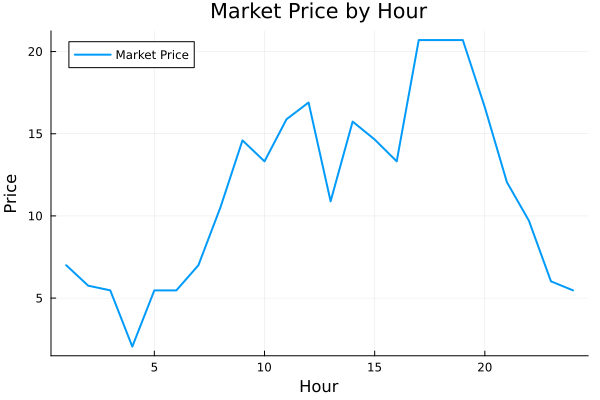

In [98]:
#plot equilibrium_df market_price in a line plot
using Plots
plot(equilibrium_df.hour, equilibrium_df.market_price, label="Market Price", xlabel="Hour", ylabel="Price", title="Market Price by Hour", lw=2)

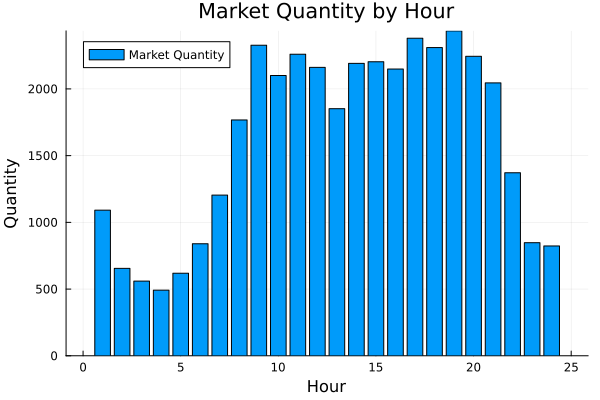

In [99]:
#plot equilibrium_df market_quantity in a bar chart
bar(equilibrium_df.hour, equilibrium_df.market_quantity, label="Market Quantity", xlabel="Hour", ylabel="Quantity", title="Market Quantity by Hour")

In [100]:
#save result_df to csv
CSV.write("results/market_clearing_Jan.csv", result_df)

"results/market_clearing_Jan.csv"